Higher Order Methods
====================

The Heun Method is an example of a more general class of numerical solvers known as Runge-Kutta solvers. See the slides for details, but basically you can classify RK solvers by the way they step in time and how they weight the extrapolated results in the final answer.

<img width="250" src="https://raw.githubusercontent.com/sspickle/sci-comp-notebooks/master/imgs/butcher-tab.png">

One particular choise of weights that is very popular is the RK4 table:

<img width="250" src="https://raw.githubusercontent.com/sspickle/sci-comp-notebooks/master/imgs/rk4-table.png">

Which leads to the RK4Step function:

    def RK4Step(s, dt, t, derivs):
        f1 = derivs(s, t)
        f2 = derivs(s+f1/2.0, t+dt/2.0)
        f3 = derivs(s+f2/2.0, t+dt/2.0)
        f4 = derivs(s+f3, t+dt)
        return s + (f1+2*f2+2*f3+f4)*dt/6.0

Symplectic Methods
==================

Some kinds of systems have properties that make even high order RK methods unsatisfactory. These are systems where Energy (and other quantities) are conserved. These are called "Hamiltonian" systems due to the extensive history of applying the Hamiltonian (Energy oriented) formalism to their solution. See the slides for more details of the Hamiltonian formalism. The RK algorithms focus on reducing trucation error, but do not respect any inherantly conserved quantities. *Symplectic* methods are designed to exactly conserve these quantities at the possible expense of some truncation error. The simplest of these is the *SymplecticEuler* method (sometimes knows as the *Cromer* method). A second order version is the *Verlet* method, or the "Leapfrog" method.

    def EulerStep(s, t, derivs, dt):
        return s + derivs(s,t)*dt

    def SymplecticEulerStep(s, t, derivs, dt):
        s1 = s + derivs(s,t,0)*dt     #  q-step
        return s1 + derivs(s1,t,1)*dt #  p-step

    def VerletStep(s, t, derivs, dt):
        dth = dt/2.0  # half of h
        s = s + derivs(s, t, 0)*dth       # changes only positon
        s = s + derivs(s, t+dth, 1)*dt    # changes only velocity
        return s + derivs(s, t+dt, 0)*dth # change only position

Notice that when the SymplecticEulerStep and VerletStep methods call derivs they add a third argument. This argument tells the derivs function whether the step is a "space step, or q-step" (pass a zero) or a "velocity step, or p-step" (pass a one). If the derivs function detects that a third argument has been passed it should return zero in the rate of change of the "other" part of the state (e.g., if it's a "space step" then the rate of change of the velocity (or momentum) should be zero). In this way the VerletStep function can carefully craft a sequence of steps that take care to conserve area in phase space (and energy in the long run, even though they may be less accurate in the short run).

Below are some examples of EulerStep, SymplecticEulerStep, RK4Step and VerletStep applied to the simple harmonic oscillator.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def EulerStep(s, t, derivs, dt):
    """
    Step whichever way derivs says to go.
    """
    return s + derivs(s,t)*dt

def SymplecticEulerStep(s, t, derivs, dt):
    """
    Take two steps, one in only "q", one in only "p" direction.
    """
    s1 = s + derivs(s,t,0)*dt     #  q-step (only change position)
    return s1 + derivs(s1,t,1)*dt #  p-step (only change momentum)

In [4]:
k=1.0
m=1.0

def derivs_sho(s, t, step=None):
    """
    Simple harmonic oscillator derivs for symplectic and non-symplectic
    The 'state' array (s) now has an ensemble of oscillators with slightly
    different initial conditions. The first n elements are the positions
    and the second half are the velocities.
    """
    n=int(len(s)/2)  # the first half of s is 'q', second half 'p'
    v=s[n:]
    
    if step==0:
        return append(v, zeros(n))  # for q-steps, just update the position
                                    # no need to compute 'a'
    else:
        x=s[:n] # only extract x and compute a if we need it.
        a=-k*x/m
        if step is None: # it must be an RK4 step
            return append(v,a)
        else: # velocity step
            return append(zeros(n),a) # for p-steps, just updated the velocity

s(at t=0)= [ 1.   1.1  1.1  1.   1.   0.   0.   0.1  0.1  0. ]


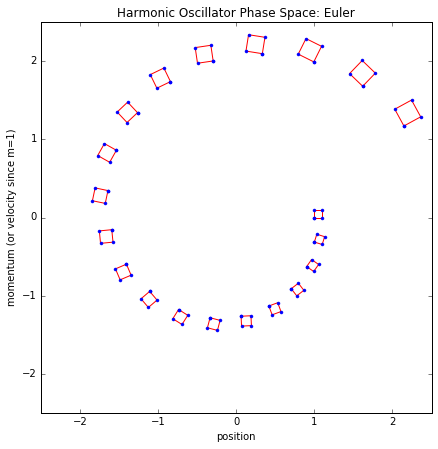

In [5]:
rcParams['figure.figsize']=(7.,7.)
DO_SYMPLECTIC=False  # Change "DO_SYMPLECTIC" to True or False to switch between
                     # SymplecticEuler and Euler "step" functions.

delta=0.1 # how far apart in phase space are the points

s0= array([1.0,0.0])
s1=s0 + array([delta, 0])
s2=s0 + array([delta,delta])
s3=s0 + array([0, delta])  # four points in phase space

t = 0.0
dt = pi/10

s = array(list(flatten(array([s0,s1,s2,s3,s0]).T)))  # state of four objects -> [x1,x2,x3,x4,x5,v1,v2,v3,v4,v5]
                                                     # (fifth object is same as first to "close the box")
print("s(at t=0)=",s)

n = int(len(s)/2)
clf()

if DO_SYMPLECTIC:
    title("Harmonic Oscillator Phase Space: Symplectic Euler")
    wsize=1.4
else:
    title("Harmonic Oscillator Phase Space: Euler")
    wsize=2.5
    
axes().set_aspect('equal')
axis([-wsize,wsize,-wsize,wsize])
xlabel("position")
ylabel("momentum (or velocity since m=1)")
plot(s[:n], s[n:], 'r-',s[:n],s[n:],'b.')

while t<1.9*pi:
    if DO_SYMPLECTIC:
        s=SymplecticEulerStep(s, t, derivs_sho, dt)
    else:
        s=EulerStep(s, t, derivs_sho, dt)
    t+=dt
    plot(s[:n], s[n:], 'r-',s[:n],s[n:],'b.')
        

In [6]:
def VerletStep(s, t, derivs, dt):
    dth = dt/2.0  # half of h
    s = s + derivs(s, t, 0)*dth       # changes only positon
    s = s + derivs(s, t+dth, 1)*dt    # changes only velocity from s1
    return s + derivs(s, t+dt, 0)*dth # change only position

def RK4Step(s, t, derivs, dt):
    """
    Take a single RK4 step.
    """
    dth=dt/2.0
    f1 = derivs(s, t)
    f2 = derivs(s+f1*dth, t+dth)
    f3 = derivs(s+f2*dth, t+dth)
    f4 = derivs(s+f3*dt, t+dt)
    return s + (f1+2*f2+2*f3+f4)*dt/6.0

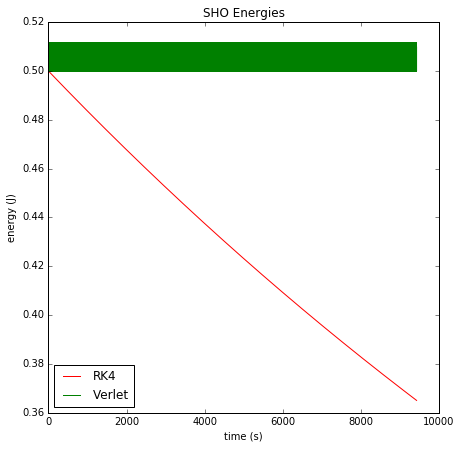

In [7]:
x=1.0
v=0.0
t=0.0
dt=0.3

tlist=[t]     # times
erlist=[0.5]  # RK4 Energies
evlist=[0.5]  # Verlet Energies
sr=array([x,v])  # state (RK4)
sv=array([x,v])  # state (Verlet)

while t<3000*pi:
    sr = RK4Step(sr, t, derivs_sho, dt)     # take each "type" of step
    sv = VerletStep(sv, t, derivs_sho, dt)
    t += dt
    tlist.append(t)
    Er = 0.5*sr[1]**2 + 0.5*sr[0]**2  # compute energies
    Ev = 0.5*sv[1]**2 + 0.5*sv[0]**2
    erlist.append(Er)
    evlist.append(Ev)
    

title("SHO Energies")
xlabel("time (s)")
ylabel("energy (J)")
plot(tlist, erlist, 'r-', label="RK4")
plot(tlist, evlist, 'g-', label="Verlet")
legend(loc=3)

Notice that the RK4 method, being 4th order, is much more "accurate" in the short term (the variations in energy are much smaller) in the long run the energy drifts a lot. The Verlet method has more short term error, but over the long run, the energy remains bounded near the original energy.

Project 4: Orbital Mechanics
=============================

You will compute the orbit of an asteroid under the influence of the Sun and Jupiter. Use the RK4 and Verlet algorithm and investigate the long term conservation of energy for both algorithms. Below find an example of approximately computing Earth's orbit about the Sun. You should be able to swich out RK4 and Verlet step functions.

What do I have to do?
---------------------

Please write a report describing your efforts. Be sure to include the following:

* The calculation of the orbital trajectory of an asteroid whose orbital period is half of Jupiter's period.

* Investigate the "long term" behavior of the results using RK4 algorithm compared to Verlet.

* A graph of energy vs. time for such an asteroid using both RK4 and Verlet methods.

* Any general conclusion you can draw from your results regarding the virtues and/or drawbacks of these methods.


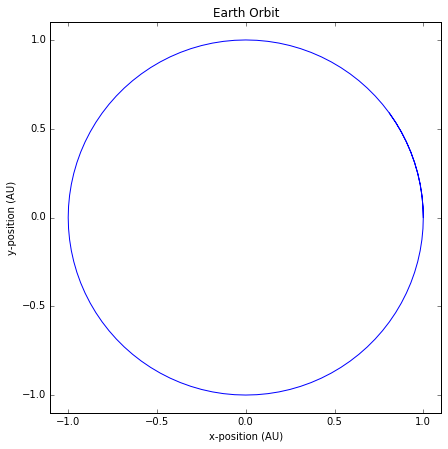

In [8]:
GMs = (2*pi)**2   # measure time in years, distance in AU

def derivs_grav(s, t, step=None):
    """
    Compute motion of Earth about the Sun
    """
    r=s[:2]
    v=s[2:]
    if step==0:  # Verlet space-step
        return append(v,zeros(2))

    else:
        rnorm = sqrt(sum(r*r))
        a = -GMs*r/rnorm**3

        if step is None:  # RK step
            return append(v,a)

        else: # Verlet velocity-step
            return append(zeros(2),a)

v = array([0.0,2*pi])
r = array([1.0,0.0])
s=append(r,v)
t=0.0
dt=0.01
tlist=[t]
xlist=[s[0]]
ylist=[s[1]]

while t<1.1:
    s = RK4Step(s, t, derivs_grav, dt)
    t += dt
    tlist.append(t)
    xlist.append(s[0])
    ylist.append(s[1])


title("Earth Orbit")
xlabel("x-position (AU)")
ylabel("y-position (AU)")
axes().set_aspect('equal')
axis([-1.1,1.1,-1.1,1.1])
plot(xlist, ylist)

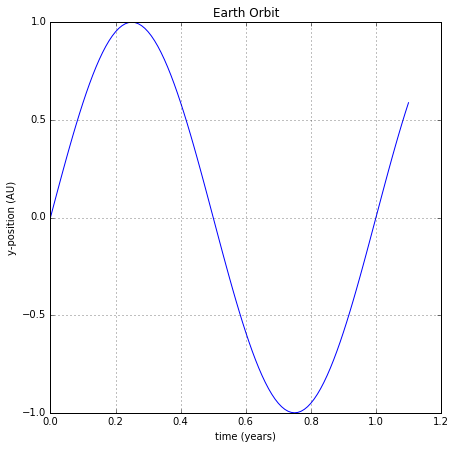

In [9]:
title("Earth Orbit")
xlabel("time (years)")
ylabel("y-position (AU)")
plot(tlist, ylist)
grid()

Starter Code
============

Below you'll find a derivs_grav function that computes the motion of an asteroid and Jupiter about the sun. It's set up to take combined q/p steps (appropriate for an RK scheme). You can use this directly to study the motion with RK4Step and investigate solutions for different initial conditions.

In [10]:
#
# This is a derivs function for the RK4 method
# You need to modify it to work with the Symplectic Integrators
#

G = (2*pi)**2   # measure time in years, distance in AU
Ms = 1.0        # mass in solar masses
Mj = Ms/1047    # jupiter's mass is much less than the Sun's
Ma = Mj/1e7     # typical asteroid mass.. *really* small.
GMs = G*Ms      # save multiplying later ...
GMj = G*Mj
GMa = G*Ma

def derivs_grav(s, t, step=None):
    """
    Compute motion of asteriod and Jupiter about the Sun
    """
    rsa=s[:2]  # position of asteroid relative to sun
    rsj=s[2:4] # for symplectic integrators it's handy to have all r's together
    va=s[4:6]  # followed by all v's in the state array.
    vj=s[6:8]  
    rja=rsa-rsj
    
    rsjm3 = (rsj*rsj).sum()**(1.5)  # compute |r_{sj}|**3 for vector force calculation
    rsam3 = (rsa*rsa).sum()**(1.5)  # similar for r_{sa}
    rjam3 = (rja*rja).sum()**(1.5)  # similar for r_{ja}
    
    aj = -(GMs*rsj/rsjm3 - GMa*rja/rjam3)
    aa = -(GMs*rsa/rsam3 + GMj*rja/rjam3)
    
    return array([va[0],va[1],vj[0],vj[1],aa[0],aa[1],aj[0],aj[1]])

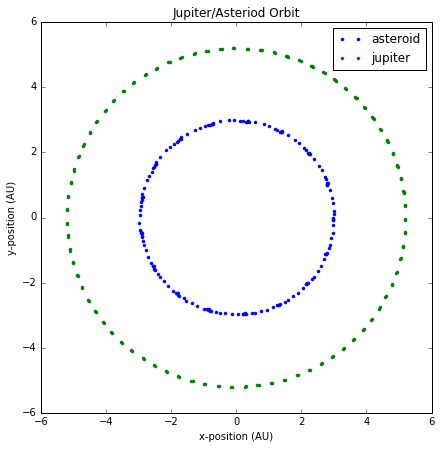

In [11]:
Rj=5.2     # AU
Ra=3.0     # AU

s=array([Ra,0,Rj,0,0,sqrt(GMs/Ra),0,sqrt(GMs/Rj)])  # assume circular orbits

xalist=[]  # empty lists
yalist=[]
tlist=[]
xjlist=[]
yjlist=[]

t=0.0
dt=0.3

while t<50:
    s=RK4Step(s, t, derivs_grav, dt)
    t+=dt
    tlist.append(t)
    xalist.append(s[0])
    yalist.append(s[1])
    xjlist.append(s[2])
    yjlist.append(s[3])
    
title("Jupiter/Asteriod Orbit")
xlabel("x-position (AU)")
ylabel("y-position (AU)")
axes().set_aspect('equal')

plot(xalist, yalist,'b.',label="asteroid")
plot(xjlist, yjlist,'g.',label="jupiter")
legend()